In [1]:
import sys
sys.path.append('..')
import pympedance.Synthesiser as imps
import numpy as np
import matplotlib.pyplot as pl
import scipy.signal as sig
%matplotlib notebook



# Acoustic environment

Creates the acoustic world containing parameters and the duct
(an inifinite duct)

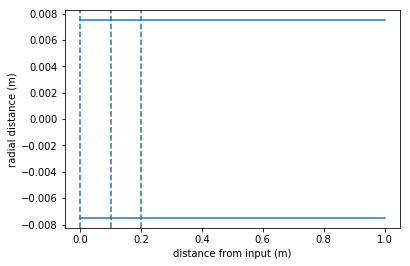

In [2]:
world = imps.AcousticWorld()

l0 = 1.0
lmid=.2

rad0 = .0075
rad_mid = .01

loss=True

mic_positions = [0,0.1,0.2]


duct = imps.Duct(world=world,losses=loss)
duct.append_element(imps.StraightDuct(length=(l0),radius=rad0))
duct.set_termination(imps.PerfectAnechoicEnd())
#duct.append_element(imps.StraightDuct(length=(l0-lmid)/2,radius=rad0))
#duct.append_element(imps.StraightDuct(length=lmid,radius=rad_mid))
#duct.append_element(imps.StraightDuct(length=(l0-lmid)/2,radius=rad0))

duct.plot_geometry()

for pos in mic_positions:
    pl.axvline(pos, ls='--')

# Check the impedance

The impedance of the infinite duct should be real and constant at all frequencies

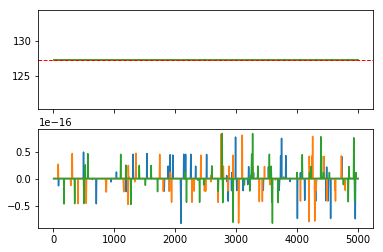

In [3]:
fvec = np.linspace(10,5000,1000)

fig,ax=pl.subplots(2,sharex=True)


for pos in mic_positions:
    z=duct.get_input_impedance_at_freq(fvec,from_pos=pos)
    
    ax[0].plot(fvec,20*np.log10(np.abs(z)))
    ax[1].plot(fvec,np.angle(z))

ax[0].axhline(20*np.log10(np.abs(duct.elements[0].get_characteristic_impedance())),
              lw=1,ls='--',color='r')

f=0
c=duct.speed_of_sound


## Get pressure ratios at microphones 

In [5]:
fvec = np.linspace(10,5000,1000)


z0=(duct.get_input_impedance_at_freq(fvec,from_pos=mic_positions[0]))
z1=(duct.get_input_impedance_at_freq(fvec,from_pos=mic_positions[1]))
z2=(duct.get_input_impedance_at_freq(fvec,from_pos=mic_positions[2]))



In [7]:
duct.transfer_mx_at_freq(freq=fvec).shape

(2, 2, 1000)

We'll impose the flow $u$ and calculate the corresponding pressure $p$

* We'll plot the impedance of the calculated signals
* We'll plot pressure ratios between the two microphones

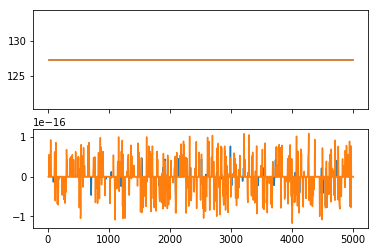

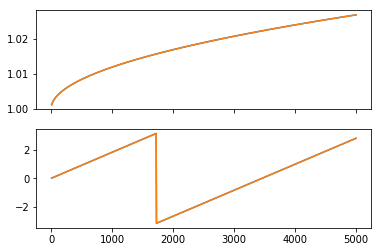

In [9]:
u0 = np.random.rand(len(fvec))-0.5 + 1j*(np.random.rand(len(fvec))-.5)

p0 = z0*u0

p1=np.zeros(len(fvec),dtype='complex128')
u1=np.zeros(len(fvec),dtype='complex128')
p2=np.zeros(len(fvec),dtype='complex128')
u2=np.zeros(len(fvec),dtype='complex128')

tmx1_arr = duct.transfer_mx_at_freq(freq=fvec, 
                                     from_pos=mic_positions[0], 
                                     to_pos=mic_positions[1])
tmx2_arr = duct.transfer_mx_at_freq(freq=fvec, 
                                 from_pos=mic_positions[0], 
                                 to_pos=mic_positions[2])

for ii,f in enumerate(fvec):
    tmx1 = tmx1_arr[:,:,ii]
    tmx2 = tmx2_arr[:,:,ii]
    v1 = np.dot(tmx1,[p0[ii],u0[ii]])
    p1[ii] = v1[0]
    u1[ii] = v1[1]
    v2 = np.dot(tmx2,[p0[ii],u0[ii]])
    p2[ii] = v2[0]
    u2[ii] = v2[1]

fig,ax=pl.subplots(2,sharex=True)
ax[0].plot(fvec,20*np.log10(np.abs(z0)))
ax[1].plot(fvec,np.angle(z0))

ax[0].plot(fvec,20*np.log10(np.abs(p0/u0)))
ax[1].plot(fvec,np.angle(p0/u0))

fig,ax=pl.subplots(2,sharex=True)

ax[0].plot(fvec,np.abs(p2/p1))
ax[0].plot(fvec,np.abs(u2/u1))
ax[1].plot(fvec,np.angle(p2/p1))
ax[1].plot(fvec,np.angle(u2/u1))


### Mic pressures relative to duct input

Check that:
* Amplitudes mic 2 < mic 1 < duct start
* Phase: linear phases, steeper for mic 2 than mic 1 (negative?)

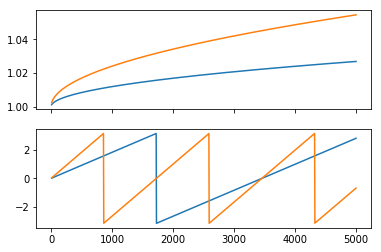

In [10]:
fig,ax=pl.subplots(2,sharex=True)

ax[0].plot(fvec,np.abs(p1/p0))
ax[0].plot(fvec,np.abs(p2/p0))
ax[1].plot(fvec,np.angle(p1/p0))
ax[1].plot(fvec,np.angle(p2/p0))


## Propagation coefficient

Check propagation coefficient
* Attenuation should be >0
* Propagation velocity below ideal

Text(0.5,0,'Frequency')

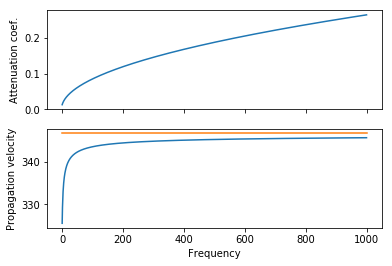

In [11]:
fig, ax = pl.subplots(2,sharex=True)
pc = []
for f in fvec:
    pc.append(duct.elements[0].get_propagation_coefficient(freq=f))
    
pc=np.array(pc)

ax[0].plot(np.real(1j*pc))
ax[0].set_ylabel('Attenuation coef.')
ax[1].plot(1./np.imag(1j*pc/2/np.pi/fvec))
ax[1].plot(duct.speed_of_sound*np.ones(len(fvec)))
ax[1].set_ylabel('Propagation velocity')
ax[1].set_xlabel('Frequency')


In [12]:
def freq_resp_to_fftfilt(respvec):
    nfft = len(respvec)
    fftfilt = np.zeros(nfft,dtype='complex')
    nnyq = int(np.ceil(nfft/float(2)))
    fftfilt[:nnyq+1] = respvec[:nnyq+1]
    fftfilt[nnyq+1:] = np.flipud(np.conjugate(fftfilt[1:nnyq]))
    if np.mod(nfft,2)==0:
        fftfilt[nnyq] = np.abs(fftfilt[nnyq])
    return fftfilt


def fft_filter(x, filtufunc=lambda x:1, sr=1.0):
    '''
    Filter signal x using FFT and IFFT
    * x input signal
    * freq_func: function of f to use to calculate gains
    
    Example:
    
    y = FFTfilter(x, lambda x: 1j*2*np.pi*x)
    
    applies a derivation filter
    '''
    
    xf = np.fft.fft(x)
    nyq = len(xf)/2
    
    fvec = np.linspace(0.1,float(sr),num=len(xf))
    #filtufunc = np.frompyfunc(freq_func)
    ffilter = filtufunc(fvec).astype('complex')
    ffilter = freq_resp_to_fftfilt(ffilter)
        
    xf_filt = xf*ffilter
    return np.fft.ifft(xf_filt) 


## Input and mic signals

In [15]:
t = 1 # sec
sr = 44100

u0_sig = np.random.rand(int(t*sr))-0.5

def filtfunc(x):
    return duct.get_input_impedance_at_freq(np.array([x]))[0]

zfunc = np.frompyfunc(filtfunc,1,1)
p0_sig = fft_filter(u0_sig, filtfunc,sr=sr)

In [16]:
def tfe_sig(y, x, *args, **kwargs):
    """estimate transfer function from x to y,
       see csd for calling convention"""
    fxy, sxy = sig.csd(y, x, *args, **kwargs)
    fxx, sxx = sig.csd(x, x, *args, **kwargs)
    return np.conj(sxy) / sxx, fxx


In [17]:
u0_sig.dtype

dtype('float64')

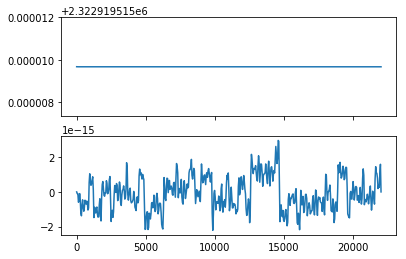

In [18]:
fig,ax=pl.subplots(2,sharex=True)
tf,ftf = tfe_sig(np.real(p0_sig),u0_sig,fs=sr,nperseg=1024)
ax[0].plot(ftf,np.abs(tf))
ax[1].plot(ftf,np.angle(tf))

In [19]:
fvecs=np.linspace(0.1,sr,len(u0_sig))
ff=zfunc(fvecs).astype('complex')
freq_resp_to_fftfilt(ff)

array([2322919.51499967+0.j, 2322919.51499967+0.j, 2322919.51499967+0.j,
       ..., 2322919.51499967-0.j, 2322919.51499967-0.j,
       2322919.51499967-0.j])

In [32]:
pf = dict()
uf = dict()

psig = dict()
usig = dict()

pos = 0.0
usig[pos] = u0_sig
uf[pos] = np.fft.fft(usig[pos])
ffilter = duct.get_input_impedance_at_freq(fvecs)
ffilter = freq_resp_to_fftfilt(ffilter)
    

pf[pos] = uf[pos]*ffilter
psig[pos] = np.real(fft_filter(u0_sig, zfunc,sr=sr))


tmf=duct.transfer_mx_at_freq(fvecs)

for pos in mic_positions:
    if pos == 0.0:
        pass
    else:
        
        
        pfv = []
        ufv = []
        tmf12 = duct.transfer_mx_at_freq(fvecs,
                                           from_pos=0.0,
                                           to_pos=pos)
        for fidx in range(tmf.shape[-1]):
            this_pf, this_uf = np.dot(tmf12[:,:,fidx],
                                      np.array([pf[0.0][fidx], uf[0.0][fidx]]))
            pfv.append(this_pf)
            ufv.append(this_uf)
            
        pf[pos]=np.array(pfv)
        uf[pos]=np.array(ufv)
        psig[pos] = np.real(np.fft.ifft(freq_resp_to_fftfilt(pf[pos])))
        usig[pos] = np.real(np.fft.ifft(freq_resp_to_fftfilt(uf[pos])))
        


In [31]:
tmf.shape

(2, 2, 44100)

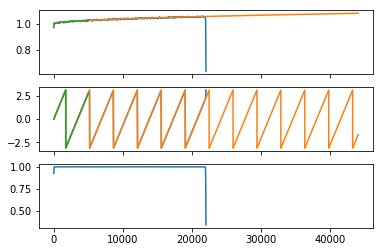

In [33]:
tf,ftf = tfe_sig(np.real(psig[0.2]),np.real(psig[0.1]),fs=sr,nperseg=1024)
_,coh = sig.coherence(np.real(psig[0.2]),np.real(psig[0.1]),fs=sr,nperseg=1024)
fig,ax=pl.subplots(3,sharex=True)

# calibration mode


ax[0].plot(ftf,np.abs(tf))
ax[0].plot(fvecs,np.abs(pf[0.2]/pf[0.1]))
ax[0].plot(fvec,np.abs(p2/p1))
ax[1].plot(ftf,np.angle(tf))
ax[1].plot(fvecs,np.angle(pf[0.2]/pf[0.1]))
ax[1].plot(fvec,np.angle(p2/p1))
ax[2].plot(ftf,coh)


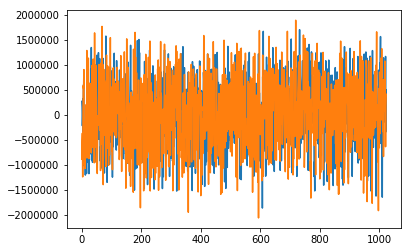

In [35]:
pl.figure()
i0=1024
n=1024
pl.plot(psig[0.1][i0:i0+n])
pl.plot(psig[0.2][i0:i0+n])
#lags = np.arange(-n+1,n)/float(sr)
#pl.plot(lags,np.correlate(psig[0.1][i0:i0+n],psig[0.2][i0:i0+n],'full'))